In [1]:
# Can I approximate playoff probs with a simple arithmetic formula?
# That would be much faster than the binomial math

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import series_probs_compute as ssim
import datasource_538 as ds

<AxesSubplot: >

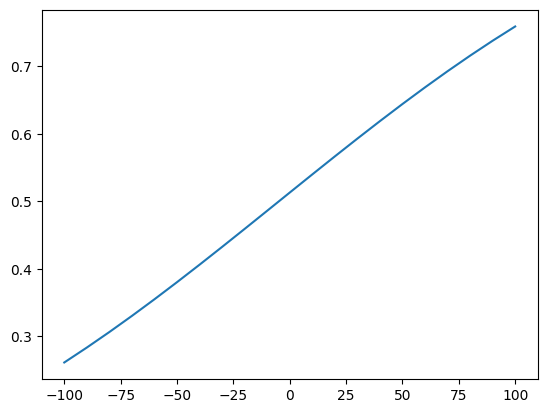

In [3]:
#  look at the distribution
base = 1500.0
probs = pd.Series({offset: ssim.p_series(5, base+offset, base) for offset in range(-100, 110, 10)})
probs.plot()

0.005333029783782338

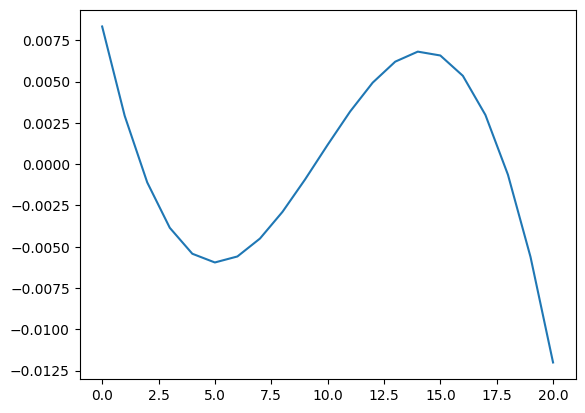

In [4]:
# looks like diminishing returns at both ends
# But let's start with a linear model and see how that does
base = 1500.0
probs = {offset: ssim.p_series(7, base+offset, base) for offset in range(-100, 110, 10)}
diffs = np.array(list(probs.keys()))
X = diffs.reshape(-1, 1)
y = list(probs.values())

model = LinearRegression().fit(X, y)

pd.Series(y - model.predict(X)).plot()
mean_squared_error( model.predict(X), y, squared=False)


0.0010026278114523251

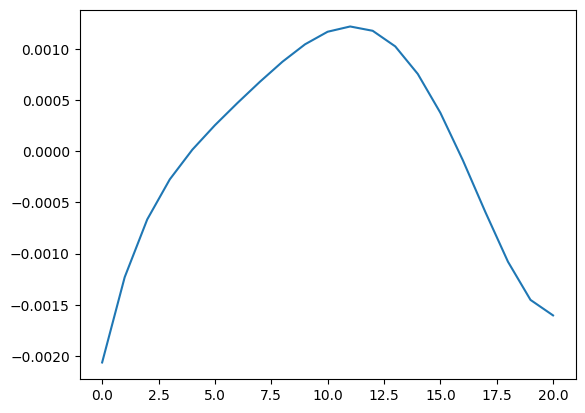

In [5]:
# Well that sure like like an x^3 curve
# Let's add a x^3 factor
base = 1500.0
probs = {offset: ssim.p_series(7, base+offset, base) for offset in range(-100, 110, 10)}
diffs = np.array(list(probs.keys()))
diffs_cu = diffs * diffs * diffs
X = list(zip(diffs, diffs_cu))
y = list(probs.values())

model = LinearRegression().fit(X, y)
pd.Series(y - model.predict(X)).plot()
mean_squared_error( model.predict(X), y, squared=False)

In [6]:
# Wow, that knocked down the error by 5x
# The remaining residual does look like an x^2, so let's add that in
base = 1500.0
probs = {offset: ssim.p_series(7, base+offset, base) for offset in range(-100, 110, 10)}
diffs = np.array(list(probs.keys()))
diffs_sq = diffs* diffs
diffs_cu = diffs * diffs * diffs
X = list(zip(diffs, diffs_sq, diffs_cu))
y = list(probs.values())

model = LinearRegression().fit(X, y)
mean_squared_error( model.predict(X), y, squared=False)

0.00015245294316337577

In [7]:
# Wow, that's another 7x reduction in error!  Let's use that model, for each series length
# The intercept represents HFA
def run_regression(num_games):
    base = 1500.0
    probs = {offset: ssim.p_series(num_games, base+offset, base) for offset in range(-100, 110, 10)}
    diffs = np.array(list(probs.keys()))
    diffs_sq = diffs* diffs
    diffs_cu = diffs * diffs * diffs
    X = list(zip(diffs, diffs_sq, diffs_cu))
    y = list(probs.values())

    model = LinearRegression().fit(X, y)
    return {'intercept': model.intercept_, 'coeffs': model.coef_}

{n: run_regression(n) for n in (3, 5, 7)}


{3: {'intercept': 0.5515680675954222,
  'coeffs': array([ 2.13649691e-03, -7.77668574e-07, -1.07862233e-08])},
 5: {'intercept': 0.5129329447206578,
  'coeffs': array([ 2.68601291e-03, -2.83159441e-07, -2.01006934e-08])},
 7: {'intercept': 0.510751390766494,
  'coeffs': array([ 3.13038537e-03, -3.03200212e-07, -3.04109537e-08])}}

In [12]:
# Let's measure error on realistic matchups
# Take the top 13 teams and take every pairing of those teams, and test the model

ratings = ds.get_ratings()
gms = [(h, a) for h in ratings.head(13) for a in ratings.head(13)]
diffs = np.array([h-a for (h,a) in gms])
diffs_sq = diffs* diffs
diffs_cu = diffs * diffs * diffs
X = list(zip(diffs, diffs_sq, diffs_cu))
y = [ssim.p_series(7, h, a) for (h, a) in gms]

mean_squared_error( model.predict(X), y, squared=False)


6.159963436285381e-05

6.159963436285381e-05